In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
#Загрузим данные
data = pd.read_csv('data_eda.csv')

In [3]:
#Выделим целевой признак и фичи
X = data.drop(columns = ['IC50, mM','CC50, mM','SI'])
y = data.loc[:,['SI']]
y['SI'] = y['SI']>8
y['SI'] = y['SI'].astype(int)

In [4]:
# Получим тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

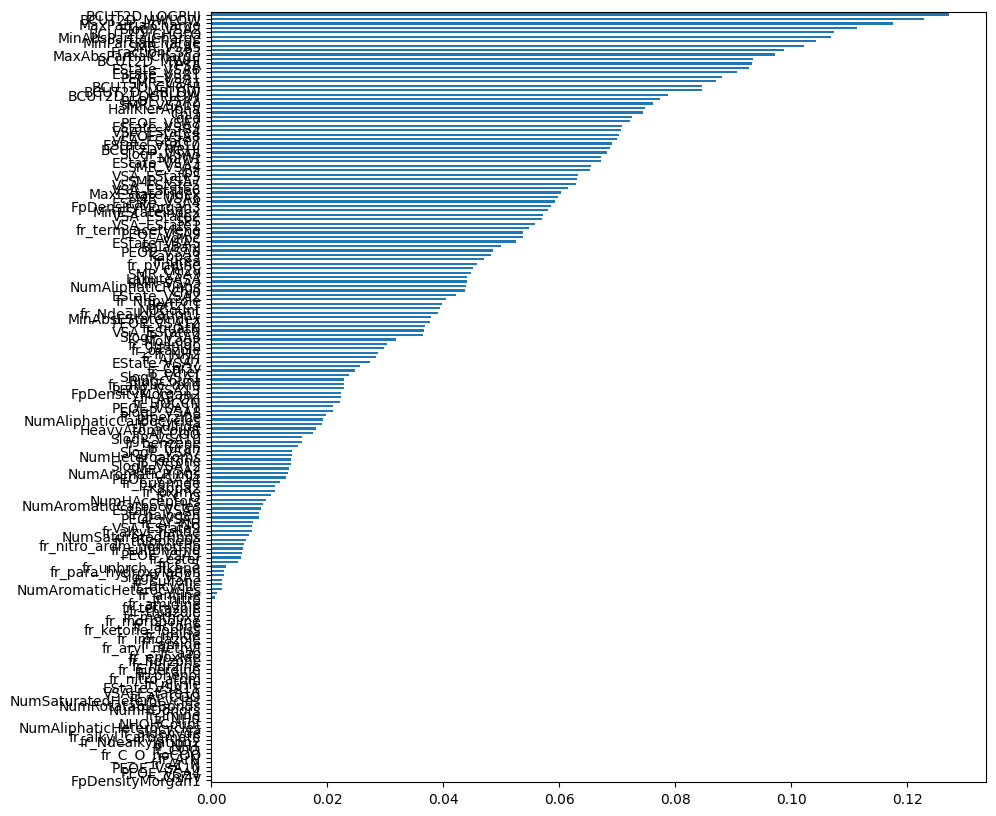

In [5]:
#Воспользуемся mutual_info_classif для feature selection
mutual = mutual_info_classif(X_train, y_train)
main_features = pd.Series(mutual, X_train.columns[0:len(X_train.columns)])
main_features = main_features.sort_values()
plt.figure(figsize=(10,10))
main_features.plot(kind='barh')
plt.show()

In [6]:
# После всех экспериментов оставим только 25 лучших признаков
selector = SelectKBest(mutual_info_classif, k=25)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

In [7]:
#Выполним масштабирование признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_sel)
X_test = scaler.transform(X_test_sel)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

<Axes: >

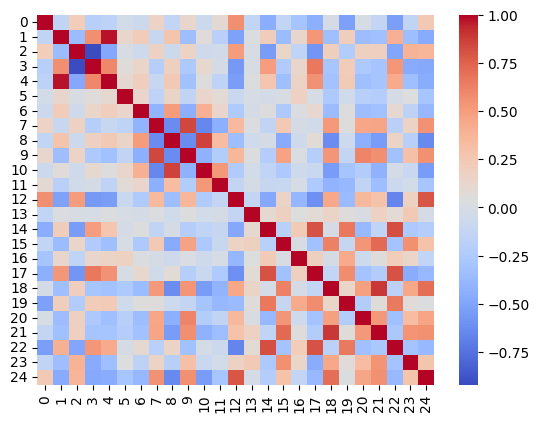

In [8]:
#Посмотрим, сколько высококореллированных признаков осталось после Feature_sel
sns.heatmap(X_train.corr(), cmap = 'coolwarm')

In [9]:
corr_mat = X_train.corr()
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col].abs()>0.9)]
print(f'Высококореллированные признаки: {high_corr}')

Высококореллированные признаки: [3, 4]


In [10]:
#Удалим высококореллированные признаки
X_train = X_train.drop(columns = [3])
X_test = X_test.drop(columns = [3])

In [11]:
#Создадим словарик с моделями перед BayesSearch
models = {
    "DecisionTree": (DecisionTreeClassifier(), {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': (2, 21),
        'model__min_samples_split': (2, 11),
        'model__min_samples_leaf': (2, 11),
    }),
    "RandomForest": (RandomForestClassifier(), {
        'model__n_estimators': (50, 500),
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': (1, 50),
        'model__min_samples_split': (2, 25),
        'model__min_samples_leaf': (2, 11),
        'model__max_features': ['sqrt', 'log2', None],
    }),
    "KNN": (KNeighborsClassifier(), {
        'model__n_neighbors': (1, 21),
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    }),
    "LogisticRegression": (LogisticRegression(solver='liblinear', max_iter=1000), {
        'model__penalty': ['l1', 'l2'],
        'model__C': (0.01, 100.0, 'log-uniform'),
        'model__fit_intercept': [True, False],
        'model__class_weight': [None, 'balanced']
    }),
    "SVC": (SVC(), {
        'model__C': (0.1, 100.0, 'log-uniform'),
        'model__kernel': ['linear', 'rbf', 'poly'], 
        'model__gamma': (0.001, 1.0, 'log-uniform'),
        'model__degree': (2, 5),
        'model__class_weight': [None, 'balanced']
    }),
    "XGBoost_Classifier": (XGBClassifier(), {
        'model__n_estimators': (100, 1000),
        'model__learning_rate': (0.01, 0.3, 'log-uniform'),
        'model__max_depth': (3, 10),
        'model__subsample': (0.6, 1.0, 'uniform'),
        'model__colsample_bytree': (0.6, 1.0, 'uniform'),
        'model__gamma': (0, 5, 'uniform'),
        'model__reg_alpha': (0, 1.0, 'uniform'),
        'model__reg_lambda': (0, 1.0, 'uniform'),
    }),
    "LightGBM_Classifier": (LGBMClassifier(), {
        'model__n_estimators': (100, 1000),
        'model__learning_rate': (0.01, 0.3, 'log-uniform'),
        'model__max_depth': (3, 10),             
        'model__num_leaves': (20, 150),
        'model__subsample': (0.6, 1.0, 'uniform'),
        'model__colsample_bytree': (0.6, 1.0, 'uniform'),
        'model__reg_alpha': (0, 1.0, 'uniform'),
        'model__reg_lambda': (0, 1.0, 'uniform'),
    })
}
# Перебор моделей
all_models_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, (model, params) in models.items():
    print(f"Обучаем {name}...")
#Добавим в пайплайн SMOTE, чтобы компенсировать дисбаланс классов
    full_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)),
    ('model', model)
    ])         
    # Байесовская оптимизация гиперпараметров
    bayes_search = BayesSearchCV(
        estimator=full_pipeline,
        search_spaces=params,
        n_iter=50,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )

    # Обучение модели
    bayes_search.fit(X_train, y_train)

    all_models_results[name] = {
        "best_params": bayes_search.best_params_,
        "best_score": bayes_search.best_score_,
        "best_model": bayes_search.best_estimator_
    }

    print(f"{name} - Accuracy: {bayes_search.best_score_:.4f}")

Обучаем DecisionTree...
DecisionTree - Accuracy: 0.6889
Обучаем RandomForest...
RandomForest - Accuracy: 0.7490
Обучаем KNN...


C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(1, 2), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
C:\Users\roman\anaconda3\envs\kursach\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [1, 2] was inferred to Integer(low=1, high=2, prior='uniform', transform='identity'). In upcoming versions of s

KNN - Accuracy: 0.7033
Обучаем LogisticRegression...
LogisticRegression - Accuracy: 0.6523
Обучаем SVC...
SVC - Accuracy: 0.7425
Обучаем XGBoost_Classifier...
XGBoost_Classifier - Accuracy: 0.7490
Обучаем LightGBM_Classifier...
[LightGBM] [Info] Number of positive: 499, number of negative: 499
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5683
[LightGBM] [Info] Number of data points in the train set: 998, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [12]:
all_models_results.items()

dict_items([('DecisionTree', {'best_params': OrderedDict({'model__criterion': 'entropy', 'model__max_depth': 19, 'model__min_samples_leaf': 5, 'model__min_samples_split': 11}), 'best_score': np.float64(0.6888888888888889), 'best_model': Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=19,
                                        min_samples_leaf=5,
                                        min_samples_split=11))])}), ('RandomForest', {'best_params': OrderedDict({'model__criterion': 'gini', 'model__max_depth': 31, 'model__max_features': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 25, 'model__n_estimators': 500}), 'best_score': np.float64(0.7490196078431373), 'best_model': Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=31, max_features=None,
                                        min_samples_le

In [13]:
for model, best_model in all_models_results.items():
    print(f'Результаты {model} на отложенной выборке:')
    y_pred = best_model['best_model'].predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    print(f'Accuracy для модели {model}: {acc}')
    print(f'Precision для модели {model}: {prec}')
    print(f'Recall для модели {model}: {rec}')

Результаты DecisionTree на отложенной выборке:
Accuracy для модели DecisionTree: 0.640625
Precision для модели DecisionTree: 0.48484848484848486
Recall для модели DecisionTree: 0.47761194029850745
Результаты RandomForest на отложенной выборке:
Accuracy для модели RandomForest: 0.6354166666666666
Precision для модели RandomForest: 0.47761194029850745
Recall для модели RandomForest: 0.47761194029850745
Результаты KNN на отложенной выборке:
Accuracy для модели KNN: 0.6302083333333334
Precision для модели KNN: 0.46875
Recall для модели KNN: 0.44776119402985076
Результаты LogisticRegression на отложенной выборке:
Accuracy для модели LogisticRegression: 0.5729166666666666
Precision для модели LogisticRegression: 0.42857142857142855
Recall для модели LogisticRegression: 0.6716417910447762
Результаты SVC на отложенной выборке:
Accuracy для модели SVC: 0.671875
Precision для модели SVC: 0.5434782608695652
Recall для модели SVC: 0.373134328358209
Результаты XGBoost_Classifier на отложенной выбор